# Project Submission

This notebook will be your project submission. All tasks will be listed in the order of the Courses that they appear in. The tasks will be the same as in the Capstone Example Notebook, but in this submission you ___MUST___ use another dataset. Failure to do so will result in a large penalty to your grade in this course.

## Finding your dataset

Take some time to find an interesting dataset! There is a reading discussing various places where datasets can be found, but if you are able to process it, go ahead and use it! Do note, for some tasks in this project, each entry will need 3+ attributes, so keep that in mind when finding datasets. After you have found your dataset, the tasks will continue as in the Example Notebook. You will be graded based on the tasks and your results. Best of luck!

### As Reviewer: 
Your job will be to verify the calculations made at each "TODO" labeled throughout the notebook.

### First Step: Imports

In the next cell we will give you all of the imports you should need to do your project. Feel free to add more if you would like, but these should be sufficient.

In [2]:
import gzip
import pandas as pd
from collections import defaultdict
import random
import numpy
import scipy.optimize
import string
from sklearn import linear_model
from nltk.stem.porter import PorterStemmer # Stemming
from collections import defaultdict

import numpy as np
from tqdm import tqdm

import os.path
RawDataPath = "reviews_music.pkl"

# Helper functions

In [3]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

def mostSimilar(i):
    similarities = []
    TopThree = []
    users = usersPerItem[i]
    for i2 in usersPerItem:
        if i2 == i: continue
        sim = Jaccard(users, usersPerItem[i2])
        similarities.append((sim,i2))
    similarities.sort(reverse=True)
    SIM = similarities[:3]
    SIM_PDT = [x[1] for x in SIM]
    return SIM,SIM_PDT

# Task 1: Data Processing

### TODO 1: Read the data and Fill your dataset

### To Reviewer: I've been using the amazon_reviews_us_Musical_Instruments_v1_00.tsv.gz dataset.

It is located [here](https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt)

It contains:
    
```
DATA COLUMNS:
marketplace       - 2 letter country code of the marketplace where the review was written.
customer_id       - Random identifier that can be used to aggregate reviews written by a single author.
review_id         - The unique ID of the review.
product_id        - The unique Product ID the review pertains to. In the multilingual dataset the reviews
                    for the same product in different countries can be grouped by the same product_id.
product_parent    - Random identifier that can be used to aggregate reviews for the same product.
product_title     - Title of the product.
product_category  - Broad product category that can be used to group reviews 
                    (also used to group the dataset into coherent parts).
star_rating       - The 1-5 star rating of the review.
helpful_votes     - Number of helpful votes.
total_votes       - Number of total votes the review received.
vine              - Review was written as part of the Vine program.
verified_purchase - The review is on a verified purchase.
review_headline   - The title of the review.
review_body       - The review text.
review_date       - The date the review was written.
```

In [4]:
import gzip
f = gzip.open("amazon_reviews_us_Musical_Instruments_v1_00.tsv.gz", 'rt', encoding="utf8")

In [5]:
header = f.readline()
header = header.strip().split('\t')
dataset = []
for line in f:
    fields = line.strip().split('\t')
    d = dict(zip(header, fields))
    d['star_rating'] = int(d['star_rating'])
    d['helpful_votes'] = int(d['helpful_votes'])
    d['total_votes'] = int(d['total_votes'])
    dataset.append(d)
dataset[0]

{'marketplace': 'US',
 'customer_id': '45610553',
 'review_id': 'RMDCHWD0Y5OZ9',
 'product_id': 'B00HH62VB6',
 'product_parent': '618218723',
 'product_title': 'AGPtek® 10 Isolated Output 9V 12V 18V Guitar Pedal Board Power Supply Effect Pedals with Isolated Short Cricuit / Overcurrent Protection',
 'product_category': 'Musical Instruments',
 'star_rating': 3,
 'helpful_votes': 0,
 'total_votes': 1,
 'vine': 'N',
 'verified_purchase': 'N',
 'review_headline': 'Three Stars',
 'review_body': 'Works very good, but induces ALOT of noise.',
 'review_date': '2015-08-31'}

In [6]:
#First we'll build a few useful data structures, in this case just to maintain a collection of the items reviewed by each user, and the collection of users who have reviewed each item.

usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)

itemNames = {}
for d in dataset:
    user,item = d['customer_id'], d['product_id']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    itemNames[item] = d['product_title']

In [7]:
dataset[3]

{'marketplace': 'US',
 'customer_id': '1546619',
 'review_id': 'R27HL570VNL85F',
 'product_id': 'B002B55TRG',
 'product_parent': '575084461',
 'product_title': 'Hohner Inc. 560BX-BF Special Twenty Harmonica',
 'product_category': 'Musical Instruments',
 'star_rating': 5,
 'helpful_votes': 0,
 'total_votes': 0,
 'vine': 'N',
 'verified_purchase': 'Y',
 'review_headline': 'I purchase these for a friend in return for playing ...',
 'review_body': 'I purchase these for a friend in return for playing them for my father and other folks at a local retirement home. Thank you R.BNGR',
 'review_date': '2015-08-31'}

In [8]:

if os.path.isfile(RawDataPath):
    table_data = pd.read_pickle(RawDataPath)
else:
    DATA = {}
    for k in range(len(dataset)):
        name = dataset[k]['review_id']
        DATA[name] = dataset[k]
    table_data = pd.DataFrame.from_dict(DATA, orient='index')
    print(len(table_data), "reviews found.")
    table_data.to_pickle(RawDataPath)
table_data["review_date"] = pd.to_datetime(table_data['review_date'])

table_data["verified"] = table_data.verified_purchase.apply(lambda x: 0 if x=="N" else 1)
table_data["vine_bool"] = table_data.vine.apply(lambda x: 0 if x=="N" else 1)

table_data.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,verified,vine_bool
RMDCHWD0Y5OZ9,US,45610553,RMDCHWD0Y5OZ9,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,3,0,1,N,N,Three Stars,"Works very good, but induces ALOT of noise.",2015-08-31,0,0
RZSL0BALIYUNU,US,14640079,RZSL0BALIYUNU,B003LRN53I,986692292,Sennheiser HD203 Closed-Back DJ Headphones,Musical Instruments,5,0,0,N,Y,Five Stars,Nice headphones at a reasonable price.,2015-08-31,1,0
RIZR67JKUDBI0,US,6111003,RIZR67JKUDBI0,B0006VMBHI,603261968,AudioQuest LP record clean brush,Musical Instruments,3,0,1,N,Y,Three Stars,removes dust. does not clean,2015-08-31,1,0
R27HL570VNL85F,US,1546619,R27HL570VNL85F,B002B55TRG,575084461,Hohner Inc. 560BX-BF Special Twenty Harmonica,Musical Instruments,5,0,0,N,Y,I purchase these for a friend in return for pl...,I purchase these for a friend in return for pl...,2015-08-31,1,0
R34EBU9QDWJ1GD,US,12222213,R34EBU9QDWJ1GD,B00N1YPXW2,165236328,Blue Yeti USB Microphone - Blackout Edition,Musical Instruments,5,0,0,N,Y,Five Stars,This is an awesome mic!,2015-08-31,1,0


## Checking most similar queries through Jaccard metrics

In [9]:
query = dataset[2]['product_id']
mostSimilar(query)

([(0.028446389496717725, 'B00006I5SD'),
  (0.01694915254237288, 'B00006I5SB'),
  (0.015065913370998116, 'B000AJR482')],
 ['B00006I5SD', 'B00006I5SB', 'B000AJR482'])

In [10]:
print(itemNames[query]) 
[itemNames[x[1]] for x in mostSimilar(query)[0]]

AudioQuest LP record clean brush


['Shure SFG-2 Stylus Tracking Force Gauge',
 'Shure M97xE High-Performance Magnetic Phono Cartridge',
 'ART Pro Audio DJPRE II Phono Turntable Preamplifier']

# Adding some features to the datasets

#### To reviewer: to make sense of what we have, I'll be adding some stats of each item, and adding some features for the sake of the exercices below. Let's start with counts of reviews per product, and average rating.

In [11]:
tqdm.pandas()

stats_products = pd.pivot_table(table_data, values = ["verified","star_rating","helpful_votes"], index=['product_id'], aggfunc={"verified":"count", "star_rating":np.mean,"helpful_votes":"sum"}, fill_value=0).reset_index()
stats_products.columns = ["product_id","helpful_total","mean_score","count_reviews"] 
stats_products.to_pickle("stats_products.pkl")
#stats_products["users"] = stats_products.product_id.progress_apply(lambda x: table_data[table_data["product_id"] == x].customer_id.unique())
stats_products

,product_id,helpful_total,mean_score,count_reviews
0,0014110024,2,4.5,2
1,0041291905,0,5.0,1
2,0046197141,2,5.0,4
3,0193757710,0,5.0,1
4,0205822908,0,5.0,1
...,...,...,...,...
123323,B014GZ52IO,2,5.0,2
123324,B014K2S348,33,5.0,1
123325,B01IBI8F86,1,5.0,2
123326,B01IBI8HKC,0,4.0,1


array([[<AxesSubplot:title={'center':'mean_score'}>]], dtype=object)

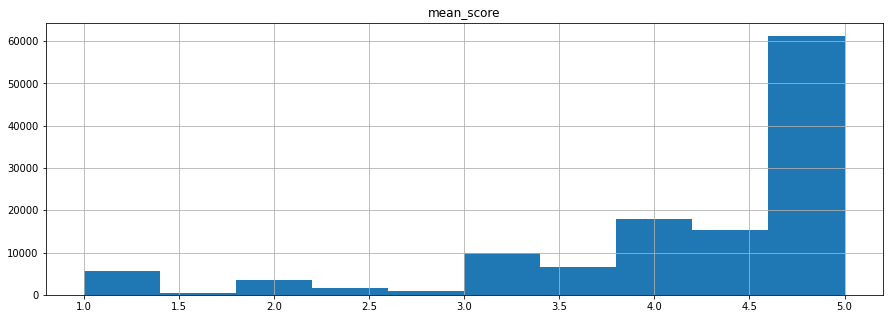

In [18]:
stats_products[["mean_score"]].hist(figsize=(15,5))

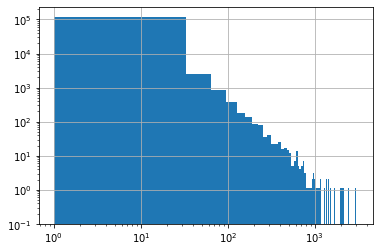

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
series = stats_products.count_reviews
fig, ax = plt.subplots()
series.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')
ax.set_xscale('log')

In [21]:
table_data = table_data.merge(stats_products,on="product_id")
table_data.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,verified,vine_bool,helpful_total,mean_score,count_reviews
0,US,45610553,RMDCHWD0Y5OZ9,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,3,0,1,N,N,Three Stars,"Works very good, but induces ALOT of noise.",2015-08-31,0,0,104,4.292683,82
1,US,49338259,R2OUC6BQXNS096,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,4,0,0,N,Y,Good for the price.,12 volt output is very noisy. Haven't tried th...,2015-08-25,1,0,104,4.292683,82
2,US,52410946,R1TSG9QDCAWHQU,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,5,0,1,N,Y,Easy to set up,Clear instructions. Easy to set up. Works gr...,2015-08-23,1,0,104,4.292683,82
3,US,30694393,RDWLI8X21ORIX,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,5,0,0,N,Y,Five Stars,Shipping time was excellent. The product works...,2015-08-23,1,0,104,4.292683,82
4,US,20618616,R3OOA1PKRGQJI0,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,1,0,1,N,Y,Stay away!,Just buy the real thing seriously this thing d...,2015-08-19,1,0,104,4.292683,82


### TODO 2: Split the data into a Training and Testing set

First shuffle your data, then split your data. Have Training be the first 80%, and testing be the remaining 20%. 

In [12]:
#YOUR CODE HERE
CutOff = len(table_data)*80//100
Training = table_data[:CutOff:]
Testing = table_data[CutOff:]
print("Len training: ",len(Training),"\nLen testing: ", len(Testing),"\nTotal count: ",len(Training)+len(Testing))
Training.to_pickle("train.pkl")
Testing.to_pickle("test.pkl")

Len training:  723812 
Len testing:  180953 
Total count:  904765


#### Now delete your dataset
You don't want any of your answers to come from your original dataset any longer, but rather your Training Set, this will help you to not make any mistakes later on, especialy when referencing the checkpoint solutions.

In [13]:
import gc
try:
    del table_data
except:
    print("Already deleted")
gc.collect() # doing some garbage collection

0

In [14]:
# Head of the training
Training.head(3)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,verified,vine_bool,helpful_total,mean_score,count_reviews
0,US,45610553,RMDCHWD0Y5OZ9,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,3,0,1,N,N,Three Stars,"Works very good, but induces ALOT of noise.",2015-08-31,0,0,104,4.292683,82
1,US,49338259,R2OUC6BQXNS096,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,4,0,0,N,Y,Good for the price.,12 volt output is very noisy. Haven't tried th...,2015-08-25,1,0,104,4.292683,82
2,US,52410946,R1TSG9QDCAWHQU,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,5,0,1,N,Y,Easy to set up,Clear instructions. Easy to set up. Works gr...,2015-08-23,1,0,104,4.292683,82


### TODO 3: Extracting Basic Statistics

Next you need to answer some questions through any means (i.e. write a function or just find the answer) all based on the __Training Set:__
1. How many entries are in your dataset?
2. Pick a non-trivial attribute (i.e. verified purchases in example), what percentage of your data has this atttribute?
3. Pick another different non-trivial attribute, what percentage of your data share both attributes?

## 0. Review of the dataset

In [15]:
# Let's check the columns we have
print(Training.keys())
# And their types
Training.dtypes

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'verified',
       'vine_bool', 'helpful_total', 'mean_score', 'count_reviews'],
      dtype='object')


marketplace                  object
customer_id                  object
review_id                    object
product_id                   object
product_parent               object
product_title                object
product_category             object
star_rating                   int64
helpful_votes                 int64
total_votes                   int64
vine                         object
verified_purchase            object
review_headline              object
review_body                  object
review_date          datetime64[ns]
verified                      int64
vine_bool                     int64
helpful_total                 int64
mean_score                  float64
count_reviews                 int64
dtype: object

In [16]:
Training.helpful_votes.sum()

1316846

### 1. Len of the training dataset

In [17]:
print("We have ",len(Training)," elements in our dataset.")

We have  723812  elements in our dataset.


### 2. Let's dig into some values of the dataset

In [18]:
# Let's see what we have.
Training.describe()

,star_rating,helpful_votes,total_votes,verified,vine_bool,helpful_total,mean_score,count_reviews
count,723812.000000,723812.000000,723812.000000,723812.000000,723812.000000,723812.000000,723812.000000,723812.000000
mean,4.281259,1.819320,2.331440,0.887507,0.002733,433.180236,4.281260,248.846991
std,1.192614,14.229547,15.065595,0.315973,0.052204,1017.023729,0.515880,494.850129
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,4.000000,0.000000,0.000000,1.000000,0.000000,20.000000,4.051151,19.000000
50%,5.000000,0.000000,0.000000,1.000000,0.000000,89.000000,4.385965,62.000000
75%,5.000000,1.000000,2.000000,1.000000,0.000000,363.000000,4.631579,223.000000
max,5.000000,4709.000000,4805.000000,1.000000,1.000000,8719.000000,5.000000,3161.000000


### 1. Results: 

* We have 89.7% of purchases that were verified.
* On average, we have 1.45 votes per review,
* and 1.07 consider a review was useful.

In [19]:
VerifiedOrNot = pd.pivot_table(Training, values='total_votes', index=['star_rating'], columns=['verified'], aggfunc="count", fill_value=0).reset_index()
VerifiedOrNot

verified,star_rating,0,1
0,1,8157,41477
1,2,4393,26110
2,3,6264,46011
3,4,14193,111445
4,5,48417,417345


### 3. Let's see if we can see poor reviews (unverified, below 2 stars)

In [20]:
PoorReviews = Training[(Training.verified == 0) & (Training.star_rating <= 2)  ]
print("There are ",len(PoorReviews),"poor reviews. This is ",len(PoorReviews)/len(Training)*1000/100,"% of the reviews.")
PoorReviews.head()

There are  12550 poor reviews. This is  0.17338756472675226 % of the reviews.


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,verified,vine_bool,helpful_total,mean_score,count_reviews
15,US,50414278,R2JLUUSOL7AKQD,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,1,0,1,N,N,looked like a handy unit,Bought on Lightning deal on Prime Day. Item ar...,2015-07-17,0,0,104,4.292683,82
132,US,10278274,RFFGNH5Q8DDCK,B003LRN53I,986692292,Sennheiser HD203 Closed-Back DJ Headphones,Musical Instruments,2,0,1,N,N,Don't believe the hype.....,I bought a pair of these from Best Buy in 2013...,2014-06-16,0,0,607,4.221429,280
231,US,13758178,RHV3XU5CRSJCA,B003LRN53I,986692292,Sennheiser HD203 Closed-Back DJ Headphones,Musical Instruments,2,0,2,N,N,So-so,"Ok pros. vs. cons. Pros - the bass, mids & tre...",2012-06-15,0,0,607,4.221429,280
248,US,17736463,R14BRNV1XHKY3G,B003LRN53I,986692292,Sennheiser HD203 Closed-Back DJ Headphones,Musical Instruments,1,9,10,N,N,Extremely painful to wear,"The \\""technical details\\"" of these headphone...",2012-02-12,0,0,607,4.221429,280
285,US,16761500,R2BKM3HMNL3BEP,B003LRN53I,986692292,Sennheiser HD203 Closed-Back DJ Headphones,Musical Instruments,1,20,25,N,N,Major Design Flaw,"First off, let me say that these Sennheiser he...",2011-11-01,0,0,607,4.221429,280


# Task 2: Classification

Next you will use our knowledge of classification to extract features and make predictions based on them. Here you will be using a Logistic Regression Model, keep this in mind so you know where to get help from.

### TODO 1: Define the feature function

This implementation will be based on ___any two___ attributes from your dataset. You will be using these two attributes to predict a third. Hint: Remember the offset


### DEFINE THE PROBLEM =)

Our problem will be to see if 

* we can predict if a Review can be considered helpful (y) - based on whether or not it was upvoted.

based on 

* given the star rating of the review is above or below the average for this object (x1)
* given it is a verified purchase or not (x2)

In [21]:
Training.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,verified,vine_bool,helpful_total,mean_score,count_reviews
0,US,45610553,RMDCHWD0Y5OZ9,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,3,0,1,N,N,Three Stars,"Works very good, but induces ALOT of noise.",2015-08-31,0,0,104,4.292683,82
1,US,49338259,R2OUC6BQXNS096,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,4,0,0,N,Y,Good for the price.,12 volt output is very noisy. Haven't tried th...,2015-08-25,1,0,104,4.292683,82
2,US,52410946,R1TSG9QDCAWHQU,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,5,0,1,N,Y,Easy to set up,Clear instructions. Easy to set up. Works gr...,2015-08-23,1,0,104,4.292683,82
3,US,30694393,RDWLI8X21ORIX,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,5,0,0,N,Y,Five Stars,Shipping time was excellent. The product works...,2015-08-23,1,0,104,4.292683,82
4,US,20618616,R3OOA1PKRGQJI0,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,1,0,1,N,Y,Stay away!,Just buy the real thing seriously this thing d...,2015-08-19,1,0,104,4.292683,82


In [22]:
# We create our filters
Training["y"]    = Training["helpful_votes"].apply(lambda x: 1 if x > 0 else 0)
Training["diff"] = Training.star_rating - Training.mean_score
Training["x1"]   = Training["diff"].apply(lambda x: 1 if x >= 0 else 0)
Training["x2"]   = Training["verified"]


Testing["y"]    = Testing["helpful_votes"].apply(lambda x: 1 if x > 0 else 0)
Testing["diff"] = Testing.star_rating - Testing.mean_score
Testing["x1"]   = Testing["diff"].apply(lambda x: 1 if x >= 0 else 0)
Testing["x2"]   = Testing["verified"]

/home/kelu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/kelu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kelu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [23]:
Training

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,...,review_date,verified,vine_bool,helpful_total,mean_score,count_reviews,y,diff,x1,x2
0,US,45610553,RMDCHWD0Y5OZ9,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,3,0,1,...,2015-08-31,0,0,104,4.292683,82,0,-1.292683,0,0
1,US,49338259,R2OUC6BQXNS096,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,4,0,0,...,2015-08-25,1,0,104,4.292683,82,0,-0.292683,0,1
2,US,52410946,R1TSG9QDCAWHQU,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,5,0,1,...,2015-08-23,1,0,104,4.292683,82,0,0.707317,1,1
3,US,30694393,RDWLI8X21ORIX,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,5,0,0,...,2015-08-23,1,0,104,4.292683,82,0,0.707317,1,1
4,US,20618616,R3OOA1PKRGQJI0,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,1,0,1,...,2015-08-19,1,0,104,4.292683,82,0,-3.292683,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723807,US,6304539,RL0FLOZLYYM6O,B00FW77P40,438854414,Kala MK-SS/WHT Makala Shark Soprano Ukulele (W...,Musical Instruments,4,0,0,...,2014-05-27,1,0,4,3.400000,5,0,0.600000,1,1
723808,US,1316050,R1EM1HVORF1YQV,B00L9SN6E4,873904888,Mooer MRV2 Sky Verb Digital Reverb with a Pair...,Musical Instruments,4,0,0,...,2015-03-06,1,0,0,4.000000,1,0,0.000000,1,1
723809,US,12063395,R1CMJMLWZT9TMT,B001RFBI6M,245362590,ProMark PB20 Pm Stick/Pad Combo Bags,Musical Instruments,5,0,0,...,2015-03-06,1,0,0,5.000000,1,0,0.000000,1,1
723810,US,52550172,R135Q8AQG1LMW,B00804G43K,973533267,African Alo Bell with stick - Metal Iron Cow B...,Musical Instruments,5,0,0,...,2015-03-06,1,0,0,4.666667,3,0,0.333333,1,1


In [24]:
Training.to_pickle("train_w_features.pkl")

In [25]:
Training.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,...,review_date,verified,vine_bool,helpful_total,mean_score,count_reviews,y,diff,x1,x2
0,US,45610553,RMDCHWD0Y5OZ9,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,3,0,1,...,2015-08-31,0,0,104,4.292683,82,0,-1.292683,0,0
1,US,49338259,R2OUC6BQXNS096,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,4,0,0,...,2015-08-25,1,0,104,4.292683,82,0,-0.292683,0,1
2,US,52410946,R1TSG9QDCAWHQU,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,5,0,1,...,2015-08-23,1,0,104,4.292683,82,0,0.707317,1,1
3,US,30694393,RDWLI8X21ORIX,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,5,0,0,...,2015-08-23,1,0,104,4.292683,82,0,0.707317,1,1
4,US,20618616,R3OOA1PKRGQJI0,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,1,0,1,...,2015-08-19,1,0,104,4.292683,82,0,-3.292683,0,1


### TODO 2: Fit your model

1. Create your __Feature Vector__ based on your feature function defined above. 
2. Create your __Label Vector__ based on the "verified purchase" column of your training set.
3. Define your model as a __Logistic Regression__ model.
4. Fit your model.

In [26]:
Training["x0"] = 1
FeatureVector = np.array(Training[["x0","x1","x2"]])
LabelVector = np.array(Training["y"])

/home/kelu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
import numpy as np
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(FeatureVector, LabelVector)

### TODO 3: Compute Accuracy of Your Model

1. Make __Predictions__ based on your model.
2. Compute the __Accuracy__ of your model.

In [28]:
from sklearn.metrics import mean_squared_error, r2_score

In [29]:
Testing["x0"] = 1
FeatureVector_test = np.array(Testing[["x0","x1","x2"]])
LabelVector_test   = np.array(Testing["y"])

/home/kelu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
Testing[["x0","x1","x2"]].describe()

,x0,x1,x2
count,180953.0,180953.000000,180953.000000
mean,1.0,0.765464,0.769343
std,0.0,0.423710,0.421254
min,1.0,0.000000,0.000000
25%,1.0,1.000000,1.000000
50%,1.0,1.000000,1.000000
75%,1.0,1.000000,1.000000
max,1.0,1.000000,1.000000


In [31]:
Testing["y"].describe()

count    180953.000000
mean          0.487099
std           0.499835
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: y, dtype: float64

In [113]:
pred = reg.predict(FeatureVector_test)
pred = [ x*4//2 for x in pred ]
Testing["Predicted_Test1"] = pred
pred

[0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0

In [114]:
LabelVector_test

array([0, 1, 0, ..., 1, 1, 1])

In [115]:
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(LabelVector_test, pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(LabelVector_test, pred))

Coefficients: 
 [ 0.         -0.08273964 -0.2101796 ]
Mean squared error: 0.42
Coefficient of determination: -0.68


In [111]:
Testing

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,...,y,diff,x1,x2,x0,txt_clean,txt_stmd,Positive,Predicted,Predicted_Test1
723812,US,49309386,RZPBZI2A969TJ,B00804G43K,973533267,African Alo Bell with stick - Metal Iron Cow B...,Musical Instruments,5,0,0,...,0,0.333333,1,1,1,excellent instrument sounds like needs great a...,excel instrument sound like need great addit m...,1,1,0.316284
723813,US,52768707,R164ALHLW820WE,B004TXDACE,927728546,HQRP AC Adapter / Power Supply for Casio AD-5 ...,Musical Instruments,5,1,1,...,1,0.000000,1,1,1,im big fan casio keyboards synths casiotone mt...,im big fan casio keyboard synth casioton mt ca...,1,1,0.316284
723814,US,39963174,RFSZBV2N9EUU8,B003NYTIA8,453874850,Gibson Wedge Style Picks (Heavy),Musical Instruments,5,0,0,...,0,0.000000,1,0,1,best picks ive found mandolin wide shape provi...,best pick ive found mandolin wide shape provid...,1,1,0.526463
723815,US,15814400,R2I7MH1NA5KFVK,B003NYTIA8,453874850,Gibson Wedge Style Picks (Heavy),Musical Instruments,5,0,0,...,0,0.000000,1,1,1,favorite picks mandolin time last long time lo...,favorit pick mandolin time last long time lot ...,1,1,0.316284
723816,US,11181158,R3OZ9XG10EPWUI,B003NYTIA8,453874850,Gibson Wedge Style Picks (Heavy),Musical Instruments,5,0,0,...,0,0.000000,1,1,1,ran across picks telluride couple years ago fa...,ran across pick tellurid coupl year ago favori...,1,1,0.316284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904760,US,51986718,RLBJBEU5R9PNT,B00002F626,668653052,Yamaha PSS16 37-Note Portable Electronic Keyboard,Musical Instruments,4,64,66,...,1,0.250000,1,0,1,ive never purchased keyboard never thought wou...,ive never purchas keyboard never thought would...,1,1,0.526463
904761,US,50947605,R10FN99OXUBU4S,B00002F626,668653052,Yamaha PSS16 37-Note Portable Electronic Keyboard,Musical Instruments,5,29,30,...,1,1.250000,1,1,1,bought keyboard daughter everyone wants play m...,bought keyboard daughter everyon want play muc...,1,1,0.316284
904762,US,49309973,R23JDW23H1V93X,B00002F626,668653052,Yamaha PSS16 37-Note Portable Electronic Keyboard,Musical Instruments,1,4,23,...,1,-2.750000,0,0,1,ok product babys u begining use product childs...,ok product babi u begin use product child play...,0,1,0.609203
904763,US,49449899,R3GECIIU47CUEK,B00002F626,668653052,Yamaha PSS16 37-Note Portable Electronic Keyboard,Musical Instruments,5,3,14,...,1,1.250000,1,0,1,awesome product used people ages comes fun lis...,awesom product use peopl age come fun listen s...,1,1,0.526463


In [117]:
n = len(Testing)
correct = len(Testing[Testing["Predicted"] == Testing["y"]])
print("Fraction of guessed right is ",correct/n, ", which is around 1/2 chance.\nBad model. Bad model.")

Fraction of guessed right is  0.49326620724718573 , which is around 1/2 chance.
Bad model. Bad model.


### Conclusion.. this model cannot reliably predict if a review was useful or not.

### TODO 4: Finding the Balanced Error Rate

1. Compute __True__ and __False Positives__
2. Compute __True__ and __False Negatives__
3. Compute __Balanced Error Rate__ based on your above defined variables.

In [119]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(Testing["Predicted"], Testing["y"])

0.5204636727860452

## Conclusion model task 2:

#### BER is around 0.5, so it confirms we're on a bad model.

# Task 3: Regression

In this section you will start by working though two examples of altering features to further differentiate. Then you will work through how to evaluate a Regularaized model.

For this example you will be working with the dataset in the example notebook. This dataset includes reviews that you will be doing a few regression tasks on. The dataset can be found [here.](https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Home_Improvement_v1_00.tsv.gz)

### TODO 1: Unique Words in a Sample Set

We are going to work with a new dataset here, as such we are going to take a smaller portion of the set and call it a Sample Set. This is because stemming on the normal training set will take a very long time. (Feel free to change sampleSet -> reg_dataset if you would like to see the difference for yourself)

1. Count the number of unique words found within the 'review body' portion of the sample set defined below, making sure to __Ignore Punctuation and Capitalization__.
2. Count the number of unique words found within the 'review body' portion of the sample set defined below, this time with use of __Stemming,__ __Ignoring Puctuation,__ ___and___ __Capitalization__.

In [35]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/kelu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
import re

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

# All to lower
def clean_text(text):
    # remove backslash-apostrophe
    text = re.sub("\'", "", text)
    # remove everything except alphabets
    text = re.sub("[^a-zA-Z]"," ",text)
    # remove whitespaces
    text = ' '.join(text.split())
    # convert text to lowercase
    text = text.lower()
    text = remove_stopwords(text)
    
    return text

def StemText(text): 
    text  = [stemmer.stem(token) for token in text.split(" ")]
    text = " ".join(text)
    return text

In [37]:
#GIVEN for 1.
wordCount = defaultdict(int)
punctuation = set(string.punctuation)

#GIVEN for 2.
wordCountStem = defaultdict(int)
stemmer = PorterStemmer() #use stemmer.stem(stuff)

#SampleSet and y vector given


#### Let's make sure we clean well the text

In [38]:
tqdm.pandas()

Training[:10]["review_body"].progress_apply(lambda x: clean_text(x) )

100%|██████████| 10/10 [00:00<00:00, 8624.93it/s]


0                        works good induces alot noise
1    volt output noisy havent tried v yet completel...
2              clear instructions easy set works great
3           shipping time excellent product works well
4    buy real thing seriously thing didnt even turn...
5    five six stomp boxes use setup powering nine v...
6                      worked great custom pedal board
7       works well would stars leads werent dang short
8                                                legit
9    works great basic pedal applications joyo mode...
Name: review_body, dtype: object

In [39]:
tqdm.pandas()

Training["txt_clean"] = Training["review_body"].progress_apply(lambda x: clean_text(x) )

100%|██████████| 723812/723812 [00:28<00:00, 25034.07it/s]
/home/kelu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
tqdm.pandas()

Training["txt_stmd"] = Training["txt_clean"].progress_apply(lambda x: StemText(x) )

100%|██████████| 723812/723812 [07:28<00:00, 1613.05it/s]
/home/kelu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
tqdm.pandas()

Testing["txt_clean"] = Testing["review_body"].progress_apply(lambda x: clean_text(x) )
Testing["txt_stmd"] = Testing["txt_clean"].progress_apply(lambda x: StemText(x) )

100%|██████████| 180953/180953 [00:09<00:00, 19122.39it/s]
/home/kelu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 180953/180953 [02:37<00:00, 1146.53it/s]
/home/kelu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [42]:
Training.to_pickle("train_all_clean.pkl")
Testing.to_pickle("testing_all_clean.pkl")

In [3]:
Training = pd.read_pickle("train_all_clean.pkl")
Testing = pd.read_pickle("testing_all_clean.pkl")

### Metrics now !

In [44]:
len(set(" ".join(Training["txt_clean"].to_list()).split(" ")))

127891

In [45]:
len(set(" ".join(Training["txt_stmd"].to_list()).split(" ")))

92457

1. Count the number of unique words found within the 'review body' portion of the sample set defined below, making sure to __Ignore Punctuation and Capitalization__.

--> This is __127891__

2. Count the number of unique words found within the 'review body' portion of the sample set defined below, this time with use of __Stemming,__ __Ignoring Puctuation,__ ___and___ __Capitalization__.

--> Down too __92k__ once cleaned

### TODO 2: Evaluating Classifiers

1. Given the feature function and your counts vector, __Define__ your X_reg vector. (This being the X vector, simply labeled for the Regression model)
2. __Fit__ your model using a __Ridge Model__ with (alpha = 1.0, fit_intercept = True).
3. Using your model, __Make your Predictions__.
4. Find the __MSE__ between your predictions and your y_reg vector.

In [46]:
Training["Positive"] = Training.star_rating.apply(lambda x: 0 if x < 4 else 1)

In [121]:
# remove words occuring in more than 80% the documents
# remove also words occuring in less than 6 documents

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, max_features=5000)


In [122]:
y = Training["Positive"]
xtrain_tfidf = tfidf_vectorizer.fit_transform(Training["txt_stmd"])
print(np.shape(xtrain_tfidf),np.shape(y))

(723812, 5000) (723812,)


In [123]:
from sklearn.linear_model import RidgeClassifier
clf = RidgeClassifier().fit(xtrain_tfidf, y)

### Application now on testing set

In [124]:
Testing["Positive"] = Testing.star_rating.apply(lambda x: 0 if x < 4 else 1)

xtest_tfidf = tfidf_vectorizer.transform(Testing["txt_stmd"])
ytest = np.array(Testing["Positive"])

pred = clf.predict(xtest_tfidf)

In [146]:
tfidf_vectorizer.vocabulary_

{'work': 4913,
 'good': 1857,
 'induc': 2200,
 'alot': 115,
 'nois': 2885,
 'volt': 4778,
 'output': 3020,
 'noisi': 2887,
 'havent': 1988,
 'tri': 4543,
 'yet': 4973,
 'complet': 833,
 'quiet': 3403,
 'rig': 3611,
 'use': 4693,
 'guess': 1927,
 'ill': 2145,
 'power': 3266,
 'wireless': 4891,
 'origin': 2998,
 'suppli': 4264,
 'rest': 3572,
 'pedal': 3114,
 'clear': 758,
 'instruct': 2230,
 'easi': 1336,
 'set': 3809,
 'great': 1897,
 'ship': 3852,
 'time': 4458,
 'excel': 1491,
 'product': 3324,
 'well': 4843,
 'buy': 570,
 'real': 3450,
 'thing': 4412,
 'serious': 3804,
 'didnt': 1149,
 'even': 1468,
 'turn': 4581,
 'voodoo': 4781,
 'next': 2866,
 'five': 1639,
 'six': 3924,
 'stomp': 4165,
 'box': 481,
 'setup': 3811,
 'nine': 2879,
 'batteri': 341,
 'occasion': 2938,
 'strip': 4197,
 'wall': 4792,
 'wart': 4808,
 'get': 1816,
 'expens': 1510,
 'hassl': 1983,
 'order': 2994,
 'solv': 4010,
 'issu': 2284,
 'mount': 2779,
 'board': 444,
 'extra': 1527,
 'seem': 3774,
 'give': 1828,
 '

### Let's see if our coeffs work nicely..

#### Do the positive terms appear fine?

In [161]:
A = clf.coef_[0]
MAXes = A.argsort()[-20:][::-1]
for k in MAXes:
    print(k,tfidf_vectorizer.get_feature_names()[k])

1076 deduct
4925 worri
1250 downsid
3399 quibbl
2342 justic
1108 deoxit
1897 great
3132 perfectli
1908 gripe
2719 minor
3928 skeptic
2034 hesit
4218 stumbl
354 beat
1833 glad
1949 ham
1963 happier
129 amaz
4776 voila
831 complaint


In [162]:
#### Do the negative terms appear fine?

In [163]:
A = clf.coef_[0]
MAXes = A.argsort()[:20][::-1]
for k in MAXes:
    print(k,tfidf_vectorizer.get_feature_names()[k])

3830 shame
2182 inconsist
4642 unfortun
4931 worthless
518 broke
3244 poorli
2087 horribl
4385 terribl
4635 underwhelm
4813 wast
2725 mislead
1552 fals
4669 unus
1178 disappoint
1083 defeat
3243 poor
4695 useless
4928 worst
3587 return
4620 unaccept


In [164]:
Testing["Predicted"] = pred

In [165]:
np.mean(pred)

0.8692864998093428

In [166]:
# The coefficients
print('Coefficients: \n', clf.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(ytest, pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(ytest, pred))

Coefficients: 
 [[ 0.2123828   0.39345916  0.0644788  ... -0.17415901  0.30231778
   0.11201964]]
Mean squared error: 0.13
Coefficient of determination: 0.24


In [167]:
mean_squared_error(Testing["Predicted"], Testing["Positive"])

0.13252612556851778

In [168]:
n = len(Testing)
correct = len(Testing[Testing["Predicted"] == Testing["Positive"]])
print("Fraction of guessed right is ",correct/n, ", which is better than 1/2 chance.")

Fraction of guessed right is  0.8674738744314822 , which is better than 1/2 chance.


# Task 4: Recommendation Systems

For your final task, you will use your knowledge of simple similarity-based recommender systems to make calculate the most similar items.

The next cell contains some starter code that you will need for your tasks in this section.
Notice you should be back to using your __trainingSet__.

In [53]:
#GIVEN
attribute_1 = defaultdict(set)
attribute_2 = defaultdict(set)

### TODO 1: Fill your Dictionaries

1. For each entry in your training set, fill your default dictionaries (defined above). 

In [6]:
from surprise import Reader, Dataset, SVD
from surprise import SVD
from surprise import Dataset
import pandas as pd
from surprise.model_selection import cross_validate

### TODO 1: Fill your Dictionaries

1. Calculate the __10__ most similar entries to the __first__ entry in your dataset, using the functions defined above.

In [98]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

def mostSimilar10(i):
    similarities = []
    TopThree = []
    users = usersPerItem[i]
    for i2 in usersPerItem:
        if i2 == i: continue
        sim = Jaccard(users, usersPerItem[i2])
        similarities.append((sim,i2))
    similarities.sort(reverse=True)
    SIM = similarities[:10]
    SIM_PDT = [x[1] for x in SIM]
    return SIM,SIM_PDT


In [99]:
#YOUR CODE HERE
table_data = pd.read_pickle(RawDataPath)
table_data.head(3)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
RMDCHWD0Y5OZ9,US,45610553,RMDCHWD0Y5OZ9,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,3,0,1,N,N,Three Stars,"Works very good, but induces ALOT of noise.",2015-08-31
RZSL0BALIYUNU,US,14640079,RZSL0BALIYUNU,B003LRN53I,986692292,Sennheiser HD203 Closed-Back DJ Headphones,Musical Instruments,5,0,0,N,Y,Five Stars,Nice headphones at a reasonable price.,2015-08-31
RIZR67JKUDBI0,US,6111003,RIZR67JKUDBI0,B0006VMBHI,603261968,AudioQuest LP record clean brush,Musical Instruments,3,0,1,N,Y,Three Stars,removes dust. does not clean,2015-08-31


In [104]:
query = dataset[0]['product_id']
print(itemNames[query]) 
[itemNames[x[1]] for x in mostSimilar10(query)[0]]

AGPtek® 10 Isolated Output 9V 12V 18V Guitar Pedal Board Power Supply Effect Pedals with Isolated Short Cricuit / Overcurrent Protection


['Joyo JF-14 American Sound Effects Pedal Amplifier Simulation with Voice Control',
 'Pedaltrain Pro With Soft Case',
 'Ernie Ball Nickel Plain Single Guitar String .010 6-Pack',
 'TC Electronic Corona Chorus Pedal',
 'ISP Technologies Decimator II Noise Reduction Pedal - (New)',
 'Electro-Harmonix Nano Big Muff Guitar Distortion Effects Pedal',
 'SKB SKB-FS6 Molded Electric Guitar Case',
 'Snark SA-2 5 Pedal Daisy Chain',
 'K & M Microphone Bar',
 'BEHRINGER PREAMP/BOOSTER PB100']

Definitely on guitar stuff.

# Having a bit more fun

In [24]:
stats_products = pd.read_pickle("stats_products.pkl")
stats_products["count_reviews"].describe()
# Let's take only products that have 15 or more reviews
N = 15
TopProducts = stats_products[stats_products.count_reviews > N].product_id.unique()
table_small = table_data[table_data.product_id.isin(TopProducts)]
print("Products with reviews >",N,"represent",100*len(table_small)/len(table_data)//1,"% of the reviews.\nLet's stick with those.")
table_small.head(3)

Products with reviews > 15 represent 65.0 % of the reviews.
Let's stick with those.


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
RMDCHWD0Y5OZ9,US,45610553,RMDCHWD0Y5OZ9,B00HH62VB6,618218723,AGPtek® 10 Isolated Output 9V 12V 18V Guitar P...,Musical Instruments,3,0,1,N,N,Three Stars,"Works very good, but induces ALOT of noise.",2015-08-31
RZSL0BALIYUNU,US,14640079,RZSL0BALIYUNU,B003LRN53I,986692292,Sennheiser HD203 Closed-Back DJ Headphones,Musical Instruments,5,0,0,N,Y,Five Stars,Nice headphones at a reasonable price.,2015-08-31
RIZR67JKUDBI0,US,6111003,RIZR67JKUDBI0,B0006VMBHI,603261968,AudioQuest LP record clean brush,Musical Instruments,3,0,1,N,Y,Three Stars,removes dust. does not clean,2015-08-31


In [25]:
reader = Reader() 
dataCollective = Dataset.load_from_df(table_small[["customer_id","product_id","star_rating"]], reader)

In [27]:
# Use the famous SVD algorithm
algo = SVD()
# Run 10-fold cross-validation and then print results
result = cross_validate(algo, dataCollective, measures=['RMSE', 'MAE'], cv=3, verbose=True)
result

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.1284  1.1281  1.1218  1.1261  0.0031  
MAE (testset)     0.8461  0.8447  0.8416  0.8441  0.0019  
Fit time          30.26   30.59   39.27   33.37   4.17    
Test time         1.98    1.82    4.09    2.63    1.04    


{'test_rmse': array([1.12838724, 1.12810451, 1.12175507]),
 'test_mae': array([0.8460991 , 0.84471153, 0.84157763]),
 'fit_time': (30.26496696472168, 30.591871738433838, 39.26701903343201),
 'test_time': (1.9798643589019775, 1.820486068725586, 4.092787742614746)}

# Let's train a collaborative model

In [31]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(dataCollective, test_size=.25)

In [32]:
# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.1269


1.1268956869621805

In [105]:
### Identifying for the sake of applying our filters some users that have already a few purchases

In [47]:
df = table_small[["customer_id","product_id","star_rating"]]
Users = df.groupby(["customer_id"]).product_id.count().reset_index()
Users.columns = ["customer_id","purchases"]
Users = Users.sort_values(by="purchases",ascending=False)
UsersList = Users.customer_id.to_list()
Users

,customer_id,purchases
392022,53037408,167
249458,36979893,91
47350,13431979,84
236645,35156819,80
89572,16671442,79
...,...,...
154147,23708640,1
154146,2370855,1
154145,23708441,1
154144,23708433,1


### We select the 10th user, and see if PREDicted ratings fit what we have.

In [106]:
UID = UsersList[10]

Tentative = df[df["customer_id"] == UID].copy()
preds = Tentative.product_id.apply( lambda x: algo.predict(UID, x, verbose=False).est)
Tentative["PRED"] =     preds                                                              
Tentative.head(3)                                                       

,customer_id,product_id,star_rating,PRED
R1MSWF42O242JH,2429197,B001B4EKNC,5,4.172211
RNQZ89GK2ZCDC,2429197,B0018TBEPW,5,4.595028
R14PRHMGTYDU6R,2429197,B0002H06X2,1,3.889129


##### It's a bit generous. One star ratings get 3+. Should have been doing some more normalization of ratings.


## Now, let's check similar items, top3, for each item that was purchased.

In [61]:
ItemsToCheck = []
for item in Tentative.product_id.to_list(): 
    ItemsToCheck.append(mostSimilar(item)[1])
print(len(ItemsToCheck))
ItemsToCheck[:3]

55


[['B000MXJIL2', 'B011R091PG', 'B00UYFIQGQ'],
 ['B0018TFBGA', 'B011R091PG', 'B00UYFIQGQ'],
 ['B0002DURGW', 'B0002F5GYS', 'B000OR5928']]

In [103]:
TMP = [ " ".join(ItemsToCheck[x]) for x in range(len(ItemsToCheck))]
TMP = " ".join(TMP).split(" ") 

## Let's create a dataframe with each object, counted how many times they appear in similar objects, and give them a rating.

## Keeping only ratings above 4.5

In [96]:
dfItems = pd.DataFrame(TMP, columns =['object'])
dfItems["Nb"]= 1
dfItems = dfItems.groupby("object").count().reset_index()
dfItems["customer_id"] = UID
dfItems["reco"] = dfItems.object.apply( lambda x: algo.predict(UID, x, verbose=False).est)
dfItems = dfItems[dfItems.reco > 4.5].sort_values(by="Nb",ascending=False)
dfItems["NameOfReco"] =  dfItems.object.apply( lambda x:  itemNames[x])
dfItems[:5]

,object,Nb,customer_id,reco,NameOfReco
102,B011R091PG,26,2429197,4.693553,Caramel CS200 Solid Acacia Top Soprano Acousti...
100,B00UYFIQGQ,16,2429197,4.693553,- Shamisen & Sanshin Craft - ASOVIVA Solid Ebo...
99,B00UEH46O0,9,2429197,4.693553,Beyond 4 String Banjo Ukulele Banjolele Maple ...
9,B0002EKG80,3,2429197,4.693553,Rhythm Band Tone Block
52,B000XP0CMS,3,2429197,5.000000,Trophy Triangle 5 in.


# Great, our user `2429197` has now some recos ! For reference, the top 3 are Ukuleles - so we may not be so far off !

## Finished!

Congratulations! You are now ready to submit your work. Once you have submitted make sure to get started on your peer reviews!